# Adaptive Sampling

This notebook implements adaptive sampling, which explores under-sampled parts of the design space while exploiting the knowledge gained from previous simulation runs.  The aim is to reduce the number of samples required to train an accurate surrogate model.  
We use Lola-Voronoi based sampling, which is compatible with any surrogate model type.  
Here it is applied with a Gaussian Process model.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import time
import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go
import seaborn as sns
import numpy as np

from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, ConstantKernel)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import MDS

from besos import eppy_funcs as ef
import besos.sampling as sampling
from besos.problem import EPProblem
from besos.evaluator import EvaluatorEP
from besos.parameters import wwr, RangeParameter, FieldSelector, FilterSelector, GenericSelector, Parameter, expand_plist
from parameters import RangeParameter, CategoryParameter, expand_plist
from sampling import adaptive_sampler_lv

from parameter_sets import parameter_set

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Client Scheduler: tcp://127.0.0.1:39633 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 7.93 GB


## Define sampler settings

In [3]:
n_samples_init = 20 # initial set of samples collected using the standard low-discrepancy sampling

no_iter = 10 # number of iterations of the adaptive sampler to run
n = 4 # number of samples added per iteration

## Generate data set 

This generates an example model and the initial sampling data, see [this example](FitGPModel.ipynb).

In [4]:
parameters = parameter_set(7)
problem = EPProblem(parameters, ['Electricity:Facility'])
building = ef.get_building()
inputs = sampling.dist_sampler(sampling.lhs, problem, n_samples_init)
evaluator = EvaluatorEP(problem, building, multi = True)
outputs = evaluator.df_apply(inputs, processes = 4)
results = inputs.join(outputs)
results.head()

/home/evan/anaconda3/lib/python3.6/site-packages/besos/problem.py:77: RuntimeWarning:

Duplicate names found. (duplicate, repetitions): [('Watts per Zone Floor Area', 2)]
Attempting to fix automatically



,Wall conductivity,Attic thickness,U-Factor,Solar Heat Gain Coefficient,Watts per Zone Floor Area_0,Watts per Zone Floor Area_1,Window to Wall Ratio,Electricity:Facility
0,0.192512,0.230707,4.377895,0.963028,12.623788,10.797001,0.339849,1.987464e+09
1,0.030055,0.178445,4.137281,0.116808,10.655750,14.860440,0.265143,2.022671e+09
2,0.142297,0.254607,0.163647,0.063449,10.357826,13.197575,0.823074,1.939752e+09
3,0.151788,0.248330,1.193116,0.053216,12.896203,11.847017,0.621168,2.017213e+09
4,0.122725,0.105937,2.916164,0.289471,13.811311,11.555892,0.934410,2.051144e+09


## Initial training of Surrogate Model
Here we use a Gaussian Process surrogate model, see [here](FitGPModel.ipynb) for details.

In [5]:
train_in, test_in, train_out, test_out = train_test_split(inputs, outputs, test_size=0.2)

In [6]:
hyperparameters = {'kernel':[None,1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
                             1.0 * RationalQuadratic(length_scale=1.0, alpha=0.5),
                             #ConstantKernel(0.1, (0.01, 10.0))*(DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0))**2),
                             1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),]}

folds = 3

gp = GaussianProcessRegressor(normalize_y=True)

clf = GridSearchCV(gp, hyperparameters, iid=True, cv=folds)
clf.fit(inputs, outputs)

print(f'The best performing model $R^2$ score on the validation set: {clf.best_score_}')
print(f'The model $R^2$ parameters: {clf.best_params_}')
print(f'The best performing model $R^2$ score on a separate test set: {clf.best_estimator_.score(test_in, test_out)}')
reg = clf.best_estimator_

The best performing model $R^2$ score on the validation set: 0.5635711206151869
The model $R^2$ parameters: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
The best performing model $R^2$ score on a separate test set: 1.0


# LOLA - Voronoi sampling
Here we run our implementation of LOLA-Voronoi sampling.  
New designs to be simulated are picked around previously simulated designs with a high hybrid score $H$.

$H = V + E$ 

$H$ is used to incentives exploration $V$ and exploitation $E$.  
$V$ is the Voronoi cell size to approximate the sample density and $E$ the local-linear estimate to approximate the gradient in the neighbourhood of a sample.

In [7]:
numiter = 10
AS = adaptive_sampler_lv(train_in.values, train_out.values, n, problem, evaluator, reg, test_in, test_out, verbose = False)
AS.run(numiter)

0


1


2


3


4


5


6


7


8


9


## Visualization
We visualize the working of the adaptive sampler by reducing the input dimensionality to 2 using multi-dimensional scaling. 

Text(0.5, 0, 'No. of samples')

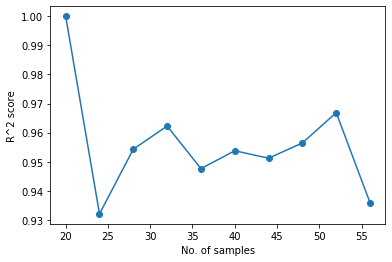

In [8]:
plt.plot(range(n_samples_init, n_samples_init + no_iter*n,n), AS.score[:-1],'-o')
plt.ylabel('R^2 score')
plt.xlabel('No. of samples')

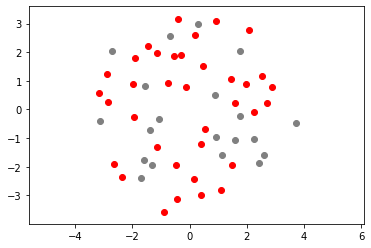

In [9]:
# Manifold model
scaler_mds = StandardScaler()
p_norm = scaler_mds.fit_transform(AS.P)
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(p_norm)

plt.scatter(out3[:n_samples_init, 0], out3[:n_samples_init, 1], color='grey')
plt.scatter(out3[n_samples_init:, 0], out3[n_samples_init:, 1], color='r')
plt.axis('equal');

(-4, 4)

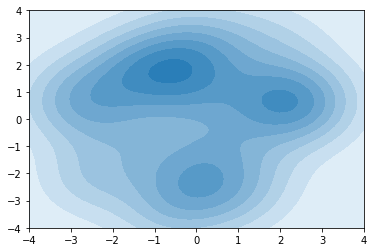

In [10]:
ax = sns.kdeplot(out3[n_samples_init:,0], out3[n_samples_init:,1], shade=True)
plt.ylim([-4,4])
plt.xlim([-4,4])

/home/evan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning:

invalid value encountered in less

/home/evan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning:

invalid value encountered in greater



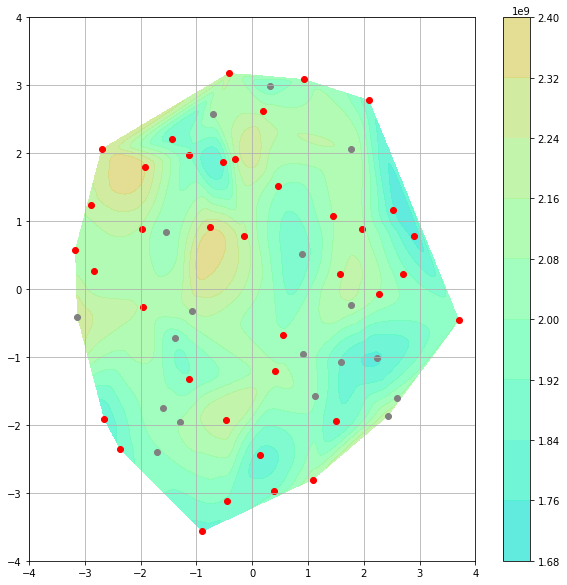

In [11]:
from scipy.interpolate import griddata
x = out3[:,0] 
y = out3[:,1]
z = reg.predict(AS.P)

# Convert from pandas dataframes to numpy arrays
X, Y, Z, = np.array([]), np.array([]), np.array([])
for i in range(len(x)):
        X = np.append(X, x[i])
        Y = np.append(Y, y[i])
        Z = np.append(Z, z[i])

# create x-y points to be used in heatmap
xi = np.linspace(X.min(), X.max(), 1000)
yi = np.linspace(Y.min(), Y.max(), 1000)

# Z is a matrix of x-y values
zi = griddata((X, Y), Z, (xi[None,:], yi[:,None]), method='cubic')

# I control the range of my colorbar by removing data 
# outside of my range of interest
zmin = 1.0*10**9
zmax = 3*10**9
zi[(zi<zmin) | (zi>zmax)] = None

# Create the contour plot
plt.figure(figsize=(10,10))
CS = plt.contourf(xi, yi, zi, 10, cmap=plt.cm.rainbow,
                  vmax=zmax, vmin=zmin, alpha=.8)
plt.colorbar()
plt.scatter(out3[:18, 0], out3[:18, 1], color='grey')
plt.scatter(out3[18:, 0], out3[18:, 1], color='r')
#ax = sns.kdeplot(out3[18:,0], out3[18:,1], shade=True)


plt.ylim([-4,4])
plt.xlim([-4,4])
plt.grid()